# Logistics Data Analysis: Parcel Delivery Performance

This notebook analyzes parcel delivery performance with a focus on Estimated Delivery Date (EDD) accuracy and broader operational insights across carriers, countries, and delivery patterns.

## Assignment Tasks
1. Data Preparation
2. Data Cleaning
3. EDA on Data
4. Feature Engineering
5. Findings & Recommendations

In [6]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style and color palette
sns.set_theme(style="whitegrid")
sns.set_palette('viridis')

# Set up figure size for better visualizations
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Preparation

In this section, we'll load the data from parquet files, explore their structure, and prepare them for analysis.

In [7]:
parcel_path = 'parcel_table.pqt'
log_path = 'log_table.pqt'
print(f"Using parcel file path: {parcel_path}")
print(f"Using log file path: {log_path}")

# Load parcel table data
parcel_df = pd.read_parquet(parcel_path)

# Load log table data
log_df = pd.read_parquet(log_path)

# Display basic info about the datasets
print("\nParcel Table Info:")
print(f"- Shape: {parcel_df.shape}")
print(f"- Number of unique parcels: {parcel_df['parcel_id'].nunique()}")

print("\nLog Table Info:")
print(f"- Shape: {log_df.shape}")
print(f"- Number of unique parcels: {log_df['parcel_id'].nunique()}")
print(f"- Number of unique log entries: {log_df['log_id'].nunique()}")

Using parcel file path: parcel_table.pqt
Using log file path: log_table.pqt

Parcel Table Info:
- Shape: (50083, 9)
- Number of unique parcels: 8727

Log Table Info:
- Shape: (94771, 6)
- Number of unique parcels: 8707
- Number of unique log entries: 8713


In [8]:
# Examine parcel table structure
print("Parcel Table Columns:")
print(parcel_df.columns.tolist())
print("\nParcel Table Sample:")
parcel_df.head()

Parcel Table Columns:
['parcel_id', 'carrier_name', 'picked_up_date', 'out_for_delivery_date', 'first_attempt_date', 'final_delivery_date', 'origin_country', 'destination_country', 'is_delivered']

Parcel Table Sample:


,parcel_id,carrier_name,picked_up_date,out_for_delivery_date,first_attempt_date,final_delivery_date,origin_country,destination_country,is_delivered
0,2981186961,Initech,2024-06-20 7:00:11,2024-06-20 20:57:51,2024-06-20 22:18:27,2024-06-20 22:18:27,Australia,Australia,True
1,2948380100,Initech,2024-06-08 6:00:06,2024-06-18 0:12:26,2024-06-18 3:33:55,2024-06-18 3:33:55,Australia,Australia,True
2,2948508927,Initech,2024-06-21 1:45:00,2024-06-21 21:53:58,2024-06-21 23:42:15,2024-06-21 23:42:15,Australia,Australia,True
3,2941258771,Initech,None,2024-06-12 0:06:19,2024-06-12 1:18:39,2024-06-12 1:18:39,Australia,Australia,True
4,2980427311,Massive,None,2024-06-22 23:09:38,2024-06-23 2:43:15,2024-06-23 2:43:15,Australia,Australia,True


In [9]:
# Examine log table structure
print("Log Table Columns:")
print(log_df.columns.tolist())
print("\nLog Table Sample:")
log_df.head()

Log Table Columns:
['log_id', 'parcel_id', 'raw_log_description', 'log_key', 'log_timestamp', 'additional_params']

Log Table Sample:


,log_id,parcel_id,raw_log_description,log_key,log_timestamp,additional_params
0,935869563,2928654176,Carrier EDD generated,EDD101,2024-06-04 0:08:08,"{""event_type_master_data_id"": ""EDD101""}"
1,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
2,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
3,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
4,910688054,2928669922,Carrier EDD generated,EDD101,2024-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"


## 2. Data Cleaning

In this section, we'll parse the JSON data in the log table, extract key metrics, handle missing values, and prepare the data for analysis.

In [10]:
# Check for missing values in parcel table
print("Missing values in parcel table:")
parcel_missing = parcel_df.isnull().sum()
print(parcel_missing[parcel_missing > 0])

# Check for missing values in log table
print("\nMissing values in log table:")
log_missing = log_df.isnull().sum()
print(log_missing[log_missing > 0])

Missing values in parcel table:
carrier_name                20
picked_up_date           28489
out_for_delivery_date      806
first_attempt_date         467
final_delivery_date        702
origin_country              23
destination_country         28
dtype: int64

Missing values in log table:
Series([], dtype: int64)


In [11]:
# Check unique log_key values to understand event types
print("Unique log_key values and their counts:")
log_key_counts = log_df['log_key'].value_counts()
print(log_key_counts)

# Check available columns in log_df
print("\nAvailable columns in log_df:")
print(log_df.columns.tolist())

print("\nCarrier distribution from parcel_df:")
carrier_counts = parcel_df['carrier_name'].value_counts()
print(carrier_counts)

Unique log_key values and their counts:
log_key
EDD101    50000
EDD102    44771
Name: count, dtype: int64

Available columns in log_df:
['log_id', 'parcel_id', 'raw_log_description', 'log_key', 'log_timestamp', 'additional_params']

Carrier distribution from parcel_df:
carrier_name
Initech    45978
Massive     3779
Globex       243
UNKNOWN       63
Name: count, dtype: int64


In [12]:
# Parse the additional_params JSON field to extract information
def parse_additional_params(params_str):
    if pd.isna(params_str) or params_str == '':
        return {}
    try:
        return json.loads(params_str)
    except Exception as e:
        print(f"Error parsing JSON: {e} - {params_str}")
        return {}

# Apply the function to extract information
log_df['parsed_params'] = log_df['additional_params'].apply(parse_additional_params)

# Filter logs related to EDD updates (based on the event_type_master_data_id in additional_params)
edd_logs = log_df[log_df['parsed_params'].apply(lambda x: x.get('event_type_master_data_id') in ['EDD101', 'EDD102'] if x else False)]

print(f"Number of EDD-related logs: {len(edd_logs)}")
print(f"Number of unique parcels with EDD logs: {edd_logs['parcel_id'].nunique()}")

# Show sample of parsed EDD logs
print("\nSample of parsed EDD logs:")
for i, (_, row) in enumerate(edd_logs.sample(3).iterrows()):
    print(f"{i+1}. Parcel ID: {row['parcel_id']}, Log Key: {row['log_key']}")
    print(f"   Parsed params: {row['parsed_params']}")

Number of EDD-related logs: 94771
Number of unique parcels with EDD logs: 8707

Sample of parsed EDD logs:
1. Parcel ID: 2936033778, Log Key: EDD101
   Parsed params: {'event_type_master_data_id': 'EDD101'}
2. Parcel ID: 2941533191, Log Key: EDD101
   Parsed params: {'event_type_master_data_id': 'EDD101'}
3. Parcel ID: 2961611446, Log Key: EDD102
   Parsed params: {'event_type_master_data_id': 'EDD102', 'new_parcel_expected_time_first_end': '2024-06-19 23:59:59', 'old_parcel_expected_time_first_end': '2024-06-19T13:59:59Z', 'new_parcel_expected_time_first_start': '2024-06-15 00:00:00', 'old_parcel_expected_time_first_start': '2024-06-14T14:00:00Z'}


In [13]:
# Extract EDD information from the parsed_params into dedicated columns
def extract_edd_dates(params):
    # Extract the newest EDD window (new_parcel_expected_time values) if available
    edd_start = params.get('new_parcel_expected_time_first_start') or params.get('new_parcel_expected_time_latest_start')
    edd_end = params.get('new_parcel_expected_time_first_end') or params.get('new_parcel_expected_time_latest_end')
    
    # If new values not available, fall back to old values
    if not edd_start:
        edd_start = params.get('old_parcel_expected_time_first_start') or params.get('old_parcel_expected_time_latest_start')
    if not edd_end:
        edd_end = params.get('old_parcel_expected_time_first_end') or params.get('old_parcel_expected_time_latest_end')
    
    return edd_start, edd_end

# Apply the extraction function to get EDD dates
edd_logs[['edd_start', 'edd_end']] = edd_logs['parsed_params'].apply(lambda x: pd.Series(extract_edd_dates(x)))

# Convert timestamps to datetime objects, handling different formats
def convert_to_datetime(ts_str):
    if pd.isna(ts_str) or ts_str == '':
        return None
    try:
        # Handle different timestamp formats and make timezone naive
        dt = pd.to_datetime(ts_str, errors='coerce')
        # Ensure timezone naive by converting to UTC and then removing timezone info
        if dt is not None and dt.tzinfo is not None:
            dt = dt.tz_convert('UTC').tz_localize(None)
        return dt
    except:
        return None

edd_logs['edd_start'] = edd_logs['edd_start'].apply(convert_to_datetime)
edd_logs['edd_end'] = edd_logs['edd_end'].apply(convert_to_datetime)

# Get the most recent EDD update for each parcel
latest_edd_logs = edd_logs.sort_values('log_timestamp', ascending=False).drop_duplicates('parcel_id')

print(f"Number of parcels with EDD information: {len(latest_edd_logs)}")
print(f"Parcels with both EDD start and end dates: {((~latest_edd_logs['edd_start'].isna()) & (~latest_edd_logs['edd_end'].isna())).sum()}")

# Display sample of EDD data
print("\nSample of extracted EDD data:")
latest_edd_logs[['parcel_id', 'log_timestamp', 'edd_start', 'edd_end']].head()

Number of parcels with EDD information: 8707
Parcels with both EDD start and end dates: 1503

Sample of extracted EDD data:


,parcel_id,log_timestamp,edd_start,edd_end
88964,2994990113,2024-06-30 9:54:53,2024-07-03 00:00:00.000,2024-07-06 23:59:59
93368,3006650651,2024-06-30 9:53:48,2024-07-12 13:59:59.999,NaT
90323,3000127840,2024-06-30 9:53:31,2024-06-30 00:00:00.000,2024-07-04 23:59:59
92326,3001181493,2024-06-30 9:46:25,2024-07-03 00:00:00.000,NaT
70388,2981880257,2024-06-30 9:45:42,2024-06-29 00:00:00.000,NaT


In [14]:
# Convert timestamp columns in parcel_df to datetime
timestamp_cols = ['picked_up_date', 'out_for_delivery_date', 'first_attempt_date', 'final_delivery_date']
for col in timestamp_cols:
    if col in parcel_df.columns:
        # Convert to datetime and ensure timezone naive
        parcel_df[col] = pd.to_datetime(parcel_df[col], errors='coerce')
        # Remove timezone info if present
        if hasattr(parcel_df[col], 'dt') and parcel_df[col].dt.tz is not None:
            parcel_df[col] = parcel_df[col].dt.tz_convert('UTC').dt.tz_localize(None)

# Also convert log timestamps
log_df['log_timestamp'] = pd.to_datetime(log_df['log_timestamp'], errors='coerce')

# Display date range coverage of the dataset
date_cols = [col for col in parcel_df.columns if 'date' in col.lower() and pd.api.types.is_datetime64_dtype(parcel_df[col])]
print("Date ranges in parcel data:")
for col in date_cols:
    if parcel_df[col].notna().any():
        print(f"{col}: {parcel_df[col].min()} to {parcel_df[col].max()}")

Date ranges in parcel data:
picked_up_date: 1970-06-05 15:48:00 to 2024-07-03 21:34:00
out_for_delivery_date: 1970-06-06 12:24:00 to 2024-07-09 22:31:46
first_attempt_date: 1970-06-06 20:28:00 to 2024-07-09 22:32:51
final_delivery_date: 1970-06-06 20:28:00 to 2024-07-09 22:32:51


## 3. Exploratory Data Analysis (EDA)

In this section, we'll explore the data to understand patterns, distributions, and relationships.

In [15]:
# Merge the EDD data with the parcel data for analysis
edd_data = latest_edd_logs[['parcel_id', 'edd_start', 'edd_end']]
analysis_df = pd.merge(parcel_df, edd_data, on='parcel_id', how='left')

# For parcels missing EDD data, estimate an EDD window from available delivery dates
missing_edd = analysis_df['edd_start'].isna() | analysis_df['edd_end'].isna()

# If out_for_delivery exists but no EDD start, use out_for_delivery as EDD start
if 'out_for_delivery_date' in analysis_df.columns:
    missing_start = missing_edd & analysis_df['edd_start'].isna() & ~analysis_df['out_for_delivery_date'].isna()
    analysis_df.loc[missing_start, 'edd_start'] = analysis_df.loc[missing_start, 'out_for_delivery_date']

# If first_attempt exists but no EDD end, use first_attempt as EDD end
if 'first_attempt_date' in analysis_df.columns:
    missing_end = missing_edd & analysis_df['edd_end'].isna() & ~analysis_df['first_attempt_date'].isna()
    analysis_df.loc[missing_end, 'edd_end'] = analysis_df.loc[missing_end, 'first_attempt_date']

# For parcels with start but no end, add 2 days to start as estimated end
start_no_end = analysis_df['edd_start'].notna() & analysis_df['edd_end'].isna()
analysis_df.loc[start_no_end, 'edd_end'] = analysis_df.loc[start_no_end, 'edd_start'] + pd.Timedelta(days=2)

# For parcels with end but no start, subtract 2 days from end as estimated start
end_no_start = analysis_df['edd_start'].isna() & analysis_df['edd_end'].notna()
analysis_df.loc[end_no_start, 'edd_start'] = analysis_df.loc[end_no_start, 'edd_end'] - pd.Timedelta(days=2)

# Final check to ensure all timestamps are timezone naive
for col in ['edd_start', 'edd_end']:
    if hasattr(analysis_df[col], 'dt') and analysis_df[col].dt.tz is not None:
        analysis_df[col] = analysis_df[col].dt.tz_convert('UTC').dt.tz_localize(None)

print(f"Total parcels in analysis dataset: {len(analysis_df)}")
print(f"Parcels with EDD information: {analysis_df['edd_start'].notna().sum()} / {len(analysis_df)}")

Total parcels in analysis dataset: 50083
Parcels with EDD information: 50037 / 50083


In [16]:
# 3.1 Delivery Success Rate Analysis
# Calculate the percentage of parcels that were successfully delivered
if 'is_delivered' in analysis_df.columns:
    delivery_success = analysis_df['is_delivered'].mean() * 100
    print(f"Overall delivery success rate: {delivery_success:.2f}%")
    
    # Delivery success by carrier
    carrier_success = analysis_df.groupby('carrier_name')['is_delivered'].mean() * 100
    carrier_success = carrier_success.sort_values(ascending=False).reset_index()
    carrier_success.columns = ['Carrier', 'Delivery Success Rate (%)']
    print("\nDelivery success rate by carrier:")
    print(carrier_success)
else:
    # If is_delivered column doesn't exist, try to derive it from final_delivery_date
    analysis_df['is_delivered'] = ~analysis_df['final_delivery_date'].isna()
    delivery_success = analysis_df['is_delivered'].mean() * 100
    print(f"Overall delivery success rate (based on final_delivery_date): {delivery_success:.2f}%")
    
    # Delivery success by carrier
    carrier_success = analysis_df.groupby('carrier_name')['is_delivered'].mean() * 100
    carrier_success = carrier_success.sort_values(ascending=False).reset_index()
    carrier_success.columns = ['Carrier', 'Delivery Success Rate (%)']
    print("\nDelivery success rate by carrier:")
    print(carrier_success)

Overall delivery success rate: 98.64%

Delivery success rate by carrier:
   Carrier  Delivery Success Rate (%)
0  UNKNOWN                     100.00
1  Initech                      98.75
2  Massive                      97.35
3   Globex                      96.71


Top 10 origin-destination country pairs:
              origin_country       destination_country  count
0                  Australia                 Australia  49396
16  United States of America                 Australia    240
3                     Canada                    Canada    211
15            United Kingdom                 Australia     72
1                  Australia  United States of America     48
17  United States of America                    Canada     25
8                    Ireland                 Australia     13
5                      China                 Australia     10
9                      Japan                 Australia      9
10                     Korea                 Australia      8


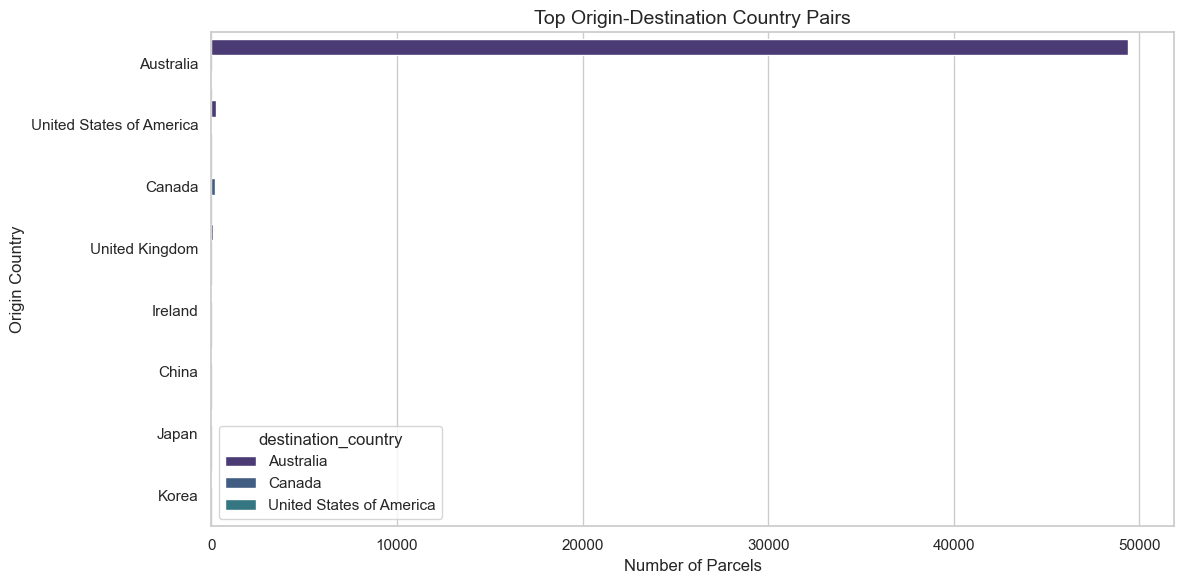


Percentage of domestic shipments: 99.05%
Percentage of international shipments: 0.95%


In [17]:
# 3.2 Origin-Destination Analysis
# Analyze the top origin-destination country pairs
if 'origin_country' in analysis_df.columns and 'destination_country' in analysis_df.columns:
    origin_dest_pairs = analysis_df.groupby(['origin_country', 'destination_country']).size().reset_index(name='count')
    origin_dest_pairs = origin_dest_pairs.sort_values('count', ascending=False).head(10)
    print("Top 10 origin-destination country pairs:")
    print(origin_dest_pairs)
    
    # Visualize top origin-destination pairs
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='count', y='origin_country', hue='destination_country', data=origin_dest_pairs)
    plt.title('Top Origin-Destination Country Pairs', fontsize=14)
    plt.xlabel('Number of Parcels', fontsize=12)
    plt.ylabel('Origin Country', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Calculate percentage of domestic vs international shipments
    analysis_df['is_domestic'] = analysis_df['origin_country'] == analysis_df['destination_country']
    domestic_pct = analysis_df['is_domestic'].mean() * 100
    print(f"\nPercentage of domestic shipments: {domestic_pct:.2f}%")
    print(f"Percentage of international shipments: {100 - domestic_pct:.2f}%")

Parcels with both EDD and delivery date: 49381 out of 50083
Fixed 9046 parcels with invalid EDD windows (start > end)

Overall EDD Accuracy:
  Delivery Status  Percentage
0         on_time       71.02
1           early       22.26
2            late        6.72


C:\Users\tran\AppData\Local\Temp\ipykernel_31212\3005162775.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels['delivery_status'] = 'unknown'
C:\Users\tran\AppData\Local\Temp\ipykernel_31212\3005162775.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Delivery Status', y='Percentage', data=delivery_summary,


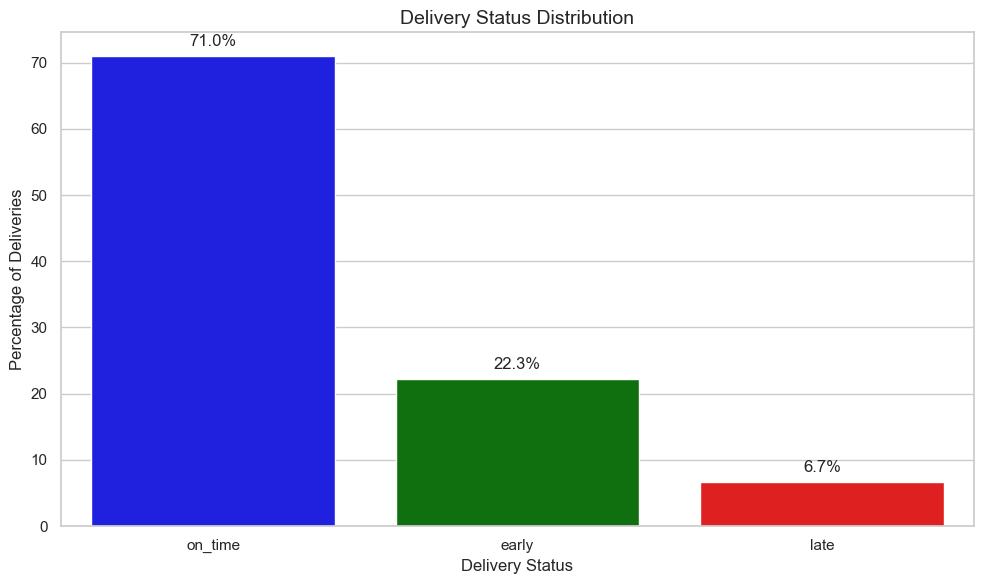

In [18]:
# 3.3 Delivery Time Analysis
# Filter for parcels with all necessary timestamps
delivered_parcels = analysis_df[(analysis_df['edd_start'].notna()) & 
                              (analysis_df['edd_end'].notna()) & 
                              (analysis_df['final_delivery_date'].notna())]

print(f"Parcels with both EDD and delivery date: {len(delivered_parcels)} out of {len(analysis_df)}")

# Verify all timestamps are timezone naive before comparing
for col in ['edd_start', 'edd_end', 'final_delivery_date']:
    if hasattr(delivered_parcels[col].dt, 'tz') and delivered_parcels[col].dt.tz is not None:
        print(f"Converting {col} to timezone naive")
        delivered_parcels[col] = delivered_parcels[col].dt.tz_convert('UTC').dt.tz_localize(None)
    
# Ensure EDD start is before EDD end (fix any data issues)
try:
    invalid_window = delivered_parcels['edd_start'] > delivered_parcels['edd_end']
    if invalid_window.any():
        print(f"Fixed {invalid_window.sum()} parcels with invalid EDD windows (start > end)")
        delivered_parcels.loc[invalid_window, ['edd_start', 'edd_end']] = delivered_parcels.loc[invalid_window, ['edd_end', 'edd_start']].values
except TypeError as e:
    print(f"Warning: {e}")
    print("Proceeding with analysis, but some EDD windows may be incorrect.")

# Classify delivery accuracy
delivered_parcels['delivery_status'] = 'unknown'

# Delivered early: before EDD start
delivered_parcels.loc[delivered_parcels['final_delivery_date'] < delivered_parcels['edd_start'], 'delivery_status'] = 'early'

# Delivered on time: within EDD window
delivered_parcels.loc[(delivered_parcels['final_delivery_date'] >= delivered_parcels['edd_start']) & 
                     (delivered_parcels['final_delivery_date'] <= delivered_parcels['edd_end']), 'delivery_status'] = 'on_time'

# Delivered late: after EDD end
delivered_parcels.loc[delivered_parcels['final_delivery_date'] > delivered_parcels['edd_end'], 'delivery_status'] = 'late'

# Calculate summary statistics
delivery_summary = delivered_parcels['delivery_status'].value_counts(normalize=True).reset_index()
delivery_summary.columns = ['Delivery Status', 'Percentage']
delivery_summary['Percentage'] = delivery_summary['Percentage'] * 100

# Display the summary
print("\nOverall EDD Accuracy:")
print(delivery_summary)

# Visualize delivery status distribution
plt.figure(figsize=(10, 6))
colors = {'early': 'green', 'on_time': 'blue', 'late': 'red', 'unknown': 'gray'}
status_order = ['early', 'on_time', 'late', 'unknown']
ax = sns.barplot(x='Delivery Status', y='Percentage', data=delivery_summary, 
                palette=[colors.get(x, 'gray') for x in delivery_summary['Delivery Status']])
plt.title('Delivery Status Distribution', fontsize=14)
plt.xlabel('Delivery Status', fontsize=12)
plt.ylabel('Percentage of Deliveries', fontsize=12)

# Add percentage labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')
    
plt.tight_layout()
plt.show()

EDD Accuracy by Carrier:
   Carrier  On-Time Delivery %
0   Globex               94.89
2  Massive               91.14
1  Initech               69.27
3  UNKNOWN               68.25

Delivery Status Distribution by Carrier (%):
delivery_status  early  late  on_time
carrier_name                         
Globex            0.00  5.10    94.90
Initech          24.20  6.60    69.30
Massive           0.00  8.90    91.10
UNKNOWN          28.60  3.20    68.30


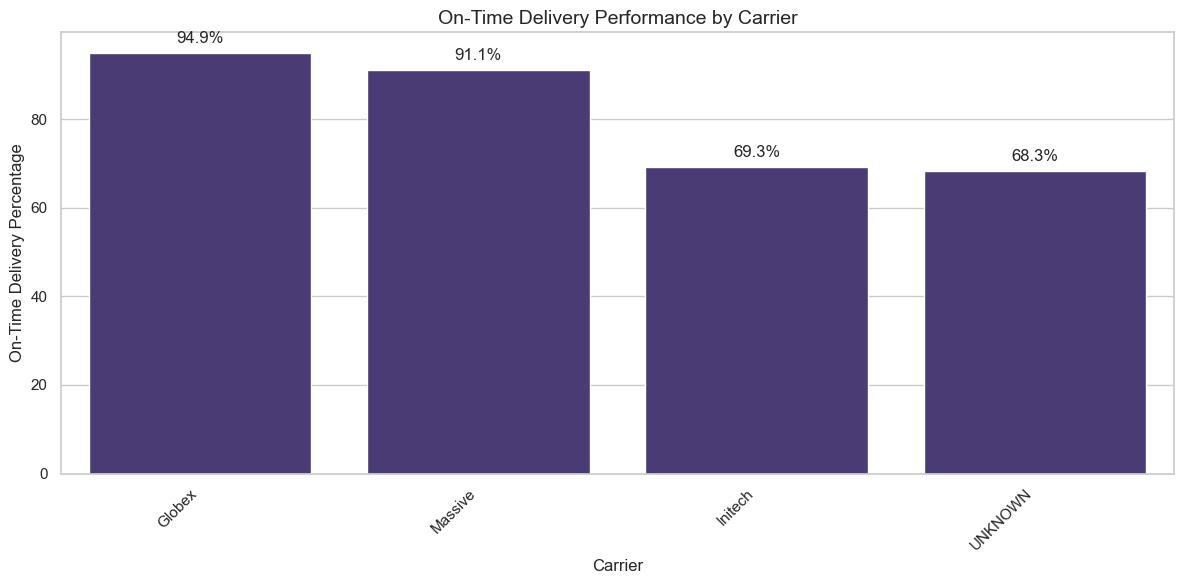

In [19]:
# 3.4 Carrier Performance Analysis
# Calculate EDD accuracy by carrier
carrier_accuracy = delivered_parcels.groupby('carrier_name')['delivery_status'].apply(
    lambda x: (x == 'on_time').mean() * 100
).reset_index()
carrier_accuracy.columns = ['Carrier', 'On-Time Delivery %']
carrier_accuracy = carrier_accuracy.sort_values('On-Time Delivery %', ascending=False)

# Display carrier accuracy
print("EDD Accuracy by Carrier:")
print(carrier_accuracy)

# Calculate detailed delivery status distribution by carrier
carrier_status = delivered_parcels.groupby(['carrier_name', 'delivery_status']).size().unstack(fill_value=0)
carrier_status_pct = carrier_status.div(carrier_status.sum(axis=1), axis=0) * 100

print("\nDelivery Status Distribution by Carrier (%):")
print(carrier_status_pct.round(1))

# Visualize carrier on-time performance
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Carrier', y='On-Time Delivery %', data=carrier_accuracy)
plt.title('On-Time Delivery Performance by Carrier', fontsize=14)
plt.xlabel('Carrier', fontsize=12)
plt.ylabel('On-Time Delivery Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

C:\Users\tran\AppData\Local\Temp\ipykernel_31212\3983831209.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels['trade_lane'] = 'International'


EDD Accuracy by Trade Lane:
delivery_status  early_pct  on_time_pct  late_pct
trade_lane                                       
Domestic             22.40        70.90      6.80
International        10.50        88.30      1.10


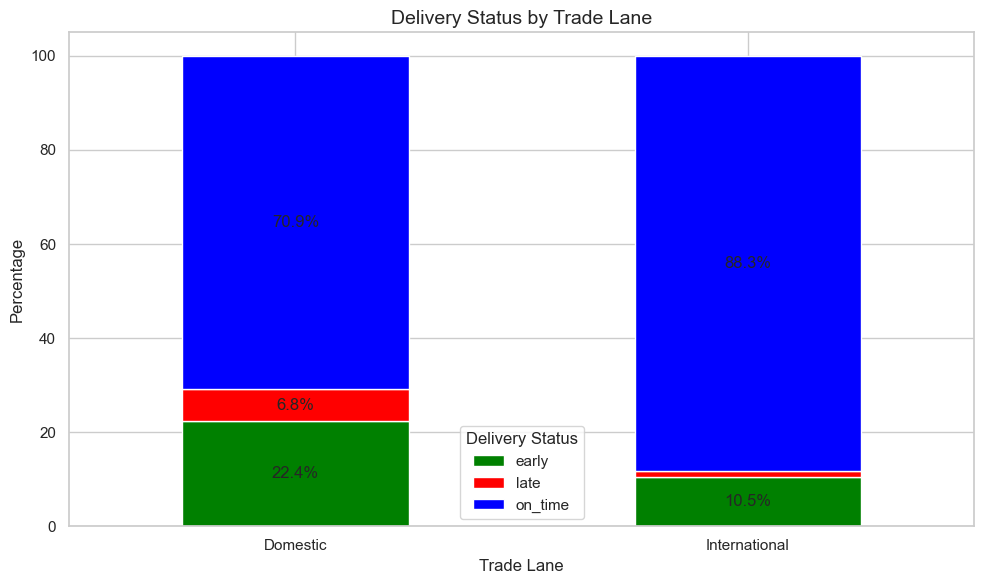

In [20]:
# 3.5 Trade Lane Analysis (Domestic vs. International)
# Add domestic/international flag
delivered_parcels['trade_lane'] = 'International'
delivered_parcels.loc[delivered_parcels['origin_country'] == delivered_parcels['destination_country'], 'trade_lane'] = 'Domestic'

# Calculate accuracy by trade lane
trade_lane_accuracy = delivered_parcels.groupby(['trade_lane', 'delivery_status']).size().unstack(fill_value=0)
trade_lane_accuracy['total'] = trade_lane_accuracy.sum(axis=1)
for status in ['early', 'on_time', 'late']:
    if status in trade_lane_accuracy.columns:
        trade_lane_accuracy[f'{status}_pct'] = trade_lane_accuracy[status] / trade_lane_accuracy['total'] * 100

# Display the results
print("EDD Accuracy by Trade Lane:")
print(trade_lane_accuracy[[col for col in trade_lane_accuracy.columns if col.endswith('_pct')]].round(1))

# Visualize trade lane accuracy with a stacked bar chart
trade_lane_status = delivered_parcels.groupby(['trade_lane', 'delivery_status']).size().reset_index(name='count')
pivot_data = trade_lane_status.pivot(index='trade_lane', columns='delivery_status', values='count').fillna(0)
pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Create stacked bar chart
colors = {'early': 'green', 'on_time': 'blue', 'late': 'red', 'unknown': 'gray'}
ax = pivot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors.get(x, 'gray') for x in pivot_data.columns])
plt.title('Delivery Status by Trade Lane', fontsize=14)
plt.xlabel('Trade Lane', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Delivery Status')
plt.xticks(rotation=0)

# Add percentage labels on the bars
for c in ax.containers:
    labels = [f'{v:.1f}%' if v > 5 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center')
    
plt.tight_layout()
plt.show()

C:\Users\tran\AppData\Local\Temp\ipykernel_31212\428468390.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels[col] = pd.to_datetime(delivered_parcels[col], errors='coerce')
C:\Users\tran\AppData\Local\Temp\ipykernel_31212\428468390.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels[col] = pd.to_datetime(delivered_parcels[col], errors='coerce')
C:\Users\tran\AppData\Local\Temp\ipykernel_31212\428468390.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy

Pickup day distribution:
pickup_day
Monday       1031
Tuesday       692
Wednesday    2102
Thursday     4887
Friday       2528
Saturday     5070
Sunday       4957
Name: count, dtype: int64


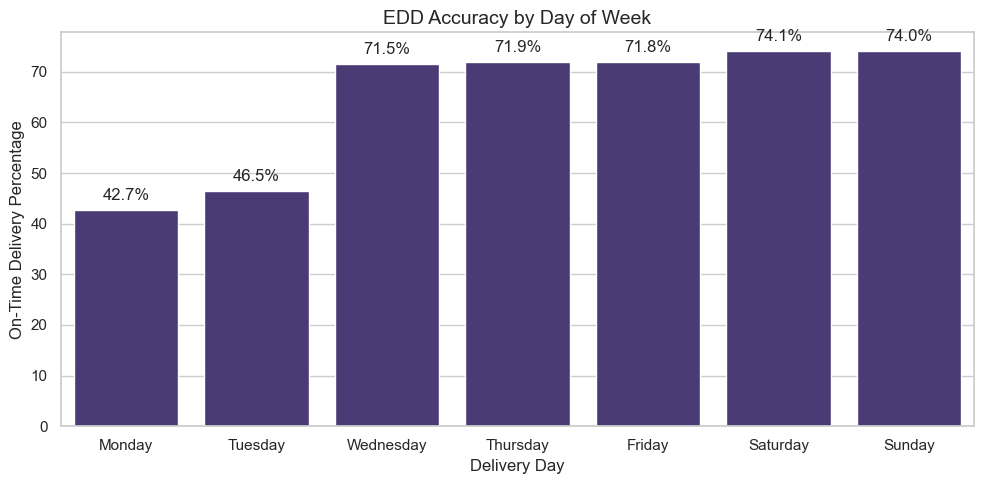


Delivery volume by month:
delivery_month
June       46475
July        2884
May           21
January        1
Name: count, dtype: int64

On-time delivery performance by month:
     Month  On-Time Delivery %
0  January                0.00
3      May               95.24
2     June               71.52
1     July               62.73


C:\Users\tran\AppData\Local\Temp\ipykernel_31212\428468390.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels['delivery_month'] = delivered_parcels['final_delivery_date'].dt.month_name()


In [21]:
# 3.6 Temporal Analysis
# Analyze day of week patterns
# Ensure date columns are properly converted to datetime format
for col in ['picked_up_date', 'final_delivery_date']:
    if col in delivered_parcels.columns:
        delivered_parcels[col] = pd.to_datetime(delivered_parcels[col], errors='coerce')

# Extract day of week for delivery dates
if 'picked_up_date' in delivered_parcels.columns and not delivered_parcels['picked_up_date'].isna().all():
    delivered_parcels['pickup_day'] = delivered_parcels['picked_up_date'].dt.day_name()
    
    # Analyze pickup day distribution
    pickup_day_counts = delivered_parcels['pickup_day'].value_counts().reindex([
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
    ])
    print("Pickup day distribution:")
    print(pickup_day_counts)

delivered_parcels['delivery_day'] = delivered_parcels['final_delivery_date'].dt.day_name()

# Calculate accuracy by delivery day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_accuracy = delivered_parcels.groupby('delivery_day')['delivery_status'].apply(
    lambda x: (x == 'on_time').mean() * 100
).reset_index()
day_accuracy.columns = ['Delivery Day', 'On-Time Delivery %']

# Convert day to categorical with proper order
day_accuracy['Day Order'] = pd.Categorical(day_accuracy['Delivery Day'], 
                                          categories=day_order, 
                                          ordered=True)
day_accuracy = day_accuracy.sort_values('Day Order')

# Visualize day of week patterns
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Delivery Day', y='On-Time Delivery %', data=day_accuracy)
plt.title('EDD Accuracy by Day of Week', fontsize=14)
plt.ylabel('On-Time Delivery Percentage', fontsize=12)

# Add value labels
for i, p in enumerate(ax.patches):
    if i < len(day_accuracy):  # Only add labels for days that exist in the data
        ax.annotate(f'{p.get_height():.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'bottom',
                    xytext = (0, 5), textcoords = 'offset points')
    
plt.tight_layout()
plt.show()

# Month analysis if data spans multiple months
# Extract month from delivery date
delivered_parcels['delivery_month'] = delivered_parcels['final_delivery_date'].dt.month_name()

# Analyze delivery volume by month
month_counts = delivered_parcels['delivery_month'].value_counts()
if len(month_counts) > 1:  # Only show if we have multiple months
    print("\nDelivery volume by month:")
    print(month_counts)
    
    # Analyze on-time performance by month
    month_accuracy = delivered_parcels.groupby('delivery_month')['delivery_status'].apply(
        lambda x: (x == 'on_time').mean() * 100
    ).reset_index()
    month_accuracy.columns = ['Month', 'On-Time Delivery %']
    
    # Convert month to categorical with proper order if needed
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
    month_accuracy['Month Order'] = pd.Categorical(month_accuracy['Month'], 
                                                 categories=month_order, 
                                                 ordered=True)
    month_accuracy = month_accuracy.sort_values('Month Order')
    
    print("\nOn-time delivery performance by month:")
    print(month_accuracy[['Month', 'On-Time Delivery %']])

## 4. Feature Engineering

In this section, we'll create new features to gain deeper insights into the delivery performance patterns.

In [22]:
# 4.1 Delivery Time Metrics
# Calculate transit times, delivery windows, and deviations

# Calculate transit time (days) if pickup date available
if 'picked_up_date' in delivered_parcels.columns and not delivered_parcels['picked_up_date'].isna().all():
    delivered_parcels['transit_time_days'] = (delivered_parcels['final_delivery_date'] - delivered_parcels['picked_up_date']).dt.total_seconds() / (24*60*60)
    # Filter out negative transit times (data errors)
    delivered_parcels.loc[delivered_parcels['transit_time_days'] < 0, 'transit_time_days'] = np.nan

# Calculate time from out-for-delivery to final delivery (last mile time)
if 'out_for_delivery_date' in delivered_parcels.columns and not delivered_parcels['out_for_delivery_date'].isna().all():
    delivered_parcels['last_mile_hours'] = (delivered_parcels['final_delivery_date'] - delivered_parcels['out_for_delivery_date']).dt.total_seconds() / 3600
    # Filter out negative times (data errors)
    delivered_parcels.loc[delivered_parcels['last_mile_hours'] < 0, 'last_mile_hours'] = np.nan

# Calculate EDD range (days)
delivered_parcels['edd_window_days'] = (delivered_parcels['edd_end'] - delivered_parcels['edd_start']).dt.total_seconds() / (24*60*60)

# Calculate deviation from EDD midpoint (days)
delivered_parcels['edd_midpoint'] = delivered_parcels['edd_start'] + (delivered_parcels['edd_end'] - delivered_parcels['edd_start']) / 2
delivered_parcels['delivery_deviation_days'] = (delivered_parcels['final_delivery_date'] - delivered_parcels['edd_midpoint']).dt.total_seconds() / (24*60*60)

# Calculate deviation percentage relative to the EDD window
delivered_parcels['deviation_percentage'] = delivered_parcels['delivery_deviation_days'] / (delivered_parcels['edd_window_days'] / 2) * 100

# Delivery attempt metric - did it need multiple attempts?
if 'first_attempt_date' in delivered_parcels.columns and 'final_delivery_date' in delivered_parcels.columns:
    delivered_parcels['multiple_attempts'] = (delivered_parcels['first_attempt_date'] != delivered_parcels['final_delivery_date']) & ~delivered_parcels['first_attempt_date'].isna()
    # Calculate success rate on first attempt
    first_attempt_success = (~delivered_parcels['multiple_attempts']).mean() * 100
    print(f"First delivery attempt success rate: {first_attempt_success:.1f}%")

# Summarize the derived metrics
metric_cols = ['transit_time_days', 'edd_window_days', 'delivery_deviation_days', 'deviation_percentage']
metric_cols = [col for col in metric_cols if col in delivered_parcels.columns]

print("\nSummary statistics for key metrics:")
for col in metric_cols:
    valid_data = delivered_parcels[col].dropna()
    # Filter to reasonable values (between 1st and 99th percentile)
    lower = valid_data.quantile(0.01)
    upper = valid_data.quantile(0.99)
    filtered = valid_data[(valid_data >= lower) & (valid_data <= upper)]
    print(f"\n{col}:")
    print(f"  Mean: {filtered.mean():.2f}")
    print(f"  Median: {filtered.median():.2f}")
    print(f"  Min: {filtered.min():.2f}")
    print(f"  Max: {filtered.max():.2f}")
    print(f"  Standard deviation: {filtered.std():.2f}")

First delivery attempt success rate: 88.6%

Summary statistics for key metrics:

transit_time_days:
  Mean: 5.03
  Median: 4.76
  Min: 0.75
  Max: 14.86
  Standard deviation: 2.76

edd_window_days:
  Mean: 2.40
  Median: 2.19
  Min: 0.01
  Max: 7.00
  Standard deviation: 1.92

delivery_deviation_days:
  Mean: -0.82
  Median: -0.50
  Min: -5.40
  Max: 8.63
  Standard deviation: 1.84

deviation_percentage:
  Mean: -20.52
  Median: -91.38
  Min: -359.95
  Max: 2116.71
  Standard deviation: 183.51


C:\Users\tran\AppData\Local\Temp\ipykernel_31212\2435750522.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels['transit_time_days'] = (delivered_parcels['final_delivery_date'] - delivered_parcels['picked_up_date']).dt.total_seconds() / (24*60*60)
C:\Users\tran\AppData\Local\Temp\ipykernel_31212\2435750522.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels['last_mile_hours'] = (delivered_parcels['final_delivery_date'] - delivered_parcels['out_for_delivery_date']).dt.tot

C:\Users\tran\AppData\Local\Temp\ipykernel_31212\300905342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels['edd_window_days_rounded'] = np.round(delivered_parcels['edd_window_days'])


On-time delivery percentage by EDD window size:
    EDD Window (Days)  On-Time Delivery %
0                0.00               93.63
1                1.00               86.86
2                2.00               47.05
3                3.00               61.02
4                4.00               69.05
5                5.00               51.19
6                6.00               55.16
7                7.00               48.90
8                8.00              100.00
9                9.00              100.00
10              10.00              100.00
11              11.00              100.00
12              12.00              100.00
13              13.00              100.00
14              14.00              100.00
15              15.00              100.00
16              16.00              100.00
17              17.00              100.00
18              18.00              100.00
19              28.00              100.00
20              32.00              100.00
21           19724.00       

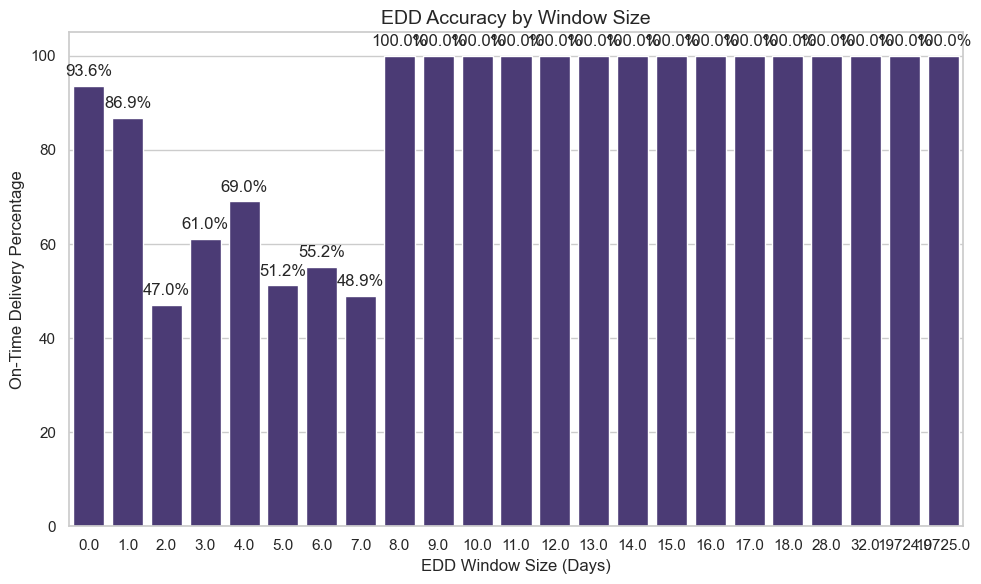

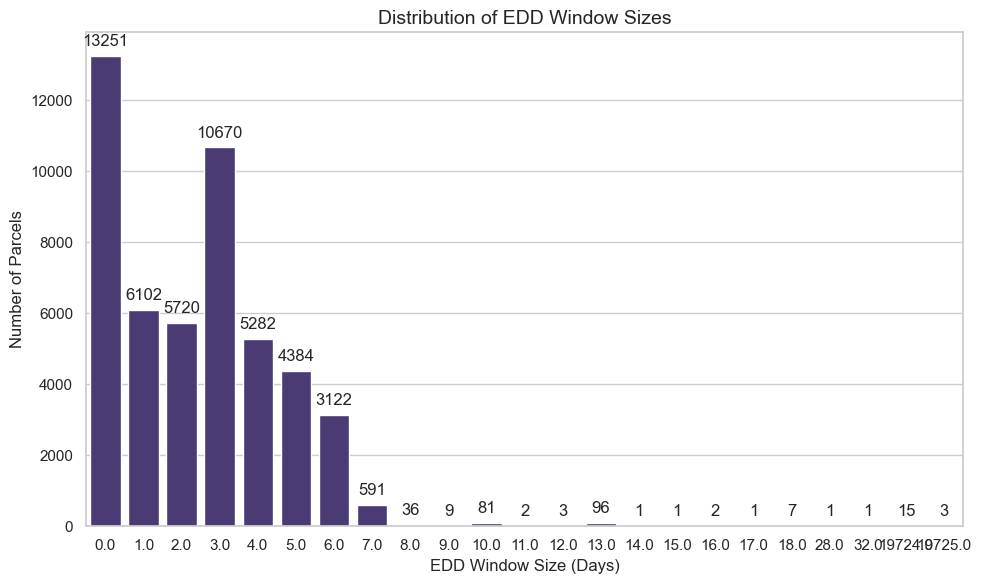

In [23]:
# 4.2 EDD Window Size Analysis
# Analyze how EDD window size affects delivery accuracy
# Group by EDD window size (rounded to nearest day)
delivered_parcels['edd_window_days_rounded'] = np.round(delivered_parcels['edd_window_days'])

window_accuracy = delivered_parcels.groupby('edd_window_days_rounded')['delivery_status'].apply(
    lambda x: (x == 'on_time').mean() * 100
).reset_index()
window_accuracy.columns = ['EDD Window (Days)', 'On-Time Delivery %']
window_accuracy = window_accuracy.sort_values('EDD Window (Days)')

# Display window size accuracy table
print("On-time delivery percentage by EDD window size:")
print(window_accuracy)

# Plot the relationship
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='EDD Window (Days)', y='On-Time Delivery %', data=window_accuracy)
plt.title('EDD Accuracy by Window Size', fontsize=14)
plt.xlabel('EDD Window Size (Days)', fontsize=12)
plt.ylabel('On-Time Delivery Percentage', fontsize=12)

# Add value labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Create window size count distribution
window_counts = delivered_parcels['edd_window_days_rounded'].value_counts().sort_index().reset_index()
window_counts.columns = ['EDD Window (Days)', 'Count']

# Plot window size distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='EDD Window (Days)', y='Count', data=window_counts)
plt.title('Distribution of EDD Window Sizes', fontsize=14)
plt.xlabel('EDD Window Size (Days)', fontsize=12)
plt.ylabel('Number of Parcels', fontsize=12)

# Add count labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

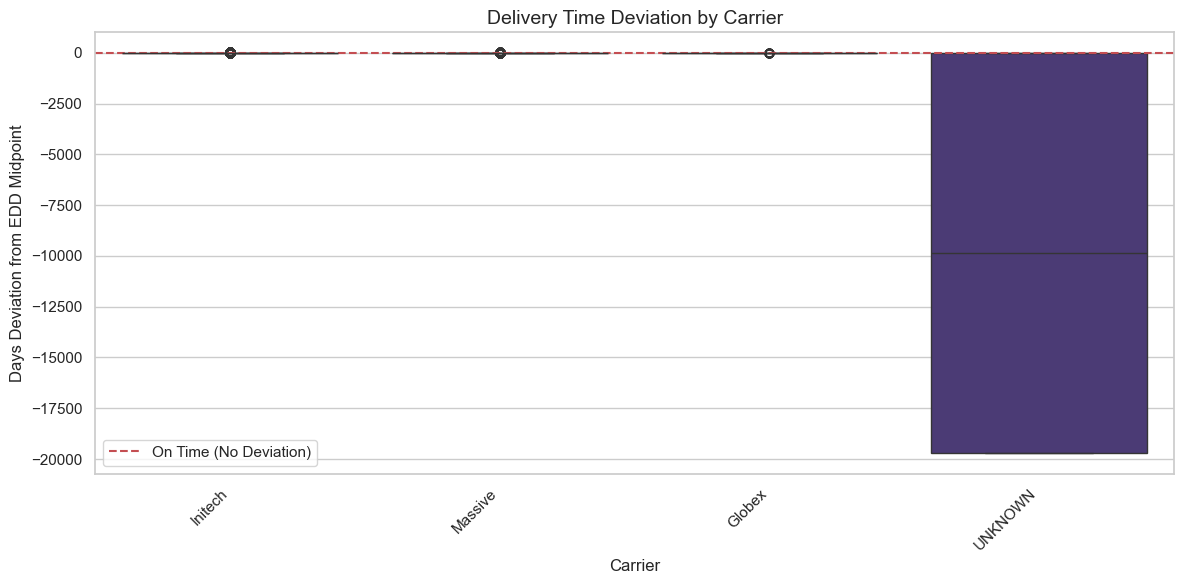

Comprehensive carrier performance metrics:
   Carrier  Parcel Count  On-Time %  Early %  Late %  Avg Transit Days  \
2   Globex           235      94.90     0.00    5.10              1.00   
1  Massive          3679      91.10     0.00    8.90              4.90   
0  Initech         45404      69.30    24.20    6.60              4.80   
3  UNKNOWN            63      68.30    28.60    3.20              5.70   

   Avg EDD Window  Avg Deviation (Days)  
2            0.20                  0.10  
1            1.40                 -0.30  
0            3.00                 -0.50  
3            6.00              -9862.00  


In [24]:
# 4.3 Carrier Performance Metrics
# Identify top carriers by volume
top_carriers = delivered_parcels['carrier_name'].value_counts().nlargest(5).index.tolist()

# Filter for top carriers
top_carrier_data = delivered_parcels[delivered_parcels['carrier_name'].isin(top_carriers)]

# Compare delivery time deviation distributions
plt.figure(figsize=(12, 6))
sns.boxplot(x='carrier_name', y='delivery_deviation_days', data=top_carrier_data)
plt.title('Delivery Time Deviation by Carrier', fontsize=14)
plt.xlabel('Carrier', fontsize=12)
plt.ylabel('Days Deviation from EDD Midpoint', fontsize=12)
plt.axhline(y=0, color='r', linestyle='--', label='On Time (No Deviation)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate carrier-specific metrics
carrier_metrics = []
for carrier in top_carriers:
    carrier_data = delivered_parcels[delivered_parcels['carrier_name'] == carrier]
    
    # Calculate various metrics
    metrics = {
        'Carrier': carrier,
        'Parcel Count': len(carrier_data),
        'On-Time %': (carrier_data['delivery_status'] == 'on_time').mean() * 100,
        'Early %': (carrier_data['delivery_status'] == 'early').mean() * 100,
        'Late %': (carrier_data['delivery_status'] == 'late').mean() * 100,
    }
    
    # Add transit time if available
    if 'transit_time_days' in carrier_data.columns and not carrier_data['transit_time_days'].isna().all():
        metrics['Avg Transit Days'] = carrier_data['transit_time_days'].median()
    
    # Add EDD window if available
    if 'edd_window_days' in carrier_data.columns:
        metrics['Avg EDD Window'] = carrier_data['edd_window_days'].median()
    
    # Add deviation metrics
    if 'delivery_deviation_days' in carrier_data.columns:
        metrics['Avg Deviation (Days)'] = carrier_data['delivery_deviation_days'].median()
    
    carrier_metrics.append(metrics)

# Create DataFrame from carrier metrics
carrier_metrics_df = pd.DataFrame(carrier_metrics)

# Sort by on-time percentage
carrier_metrics_df = carrier_metrics_df.sort_values('On-Time %', ascending=False)

# Display the metrics
print("Comprehensive carrier performance metrics:")
print(carrier_metrics_df.round(1))

On-time delivery performance by top country pairs:
                           Country Pair  On-Time Delivery %
4                   Ireland → Australia              100.00
3                     China → Australia              100.00
7            United Kingdom → Australia              100.00
6                     Korea → Australia              100.00
5                     Japan → Australia              100.00
8  United States of America → Australia               99.57
2                       Canada → Canada               95.24
9     United States of America → Canada               92.00
0                 Australia → Australia               70.76
1  Australia → United States of America                4.17


C:\Users\tran\AppData\Local\Temp\ipykernel_31212\70349454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels['country_pair'] = delivered_parcels['origin_country'] + ' → ' + delivered_parcels['destination_country']


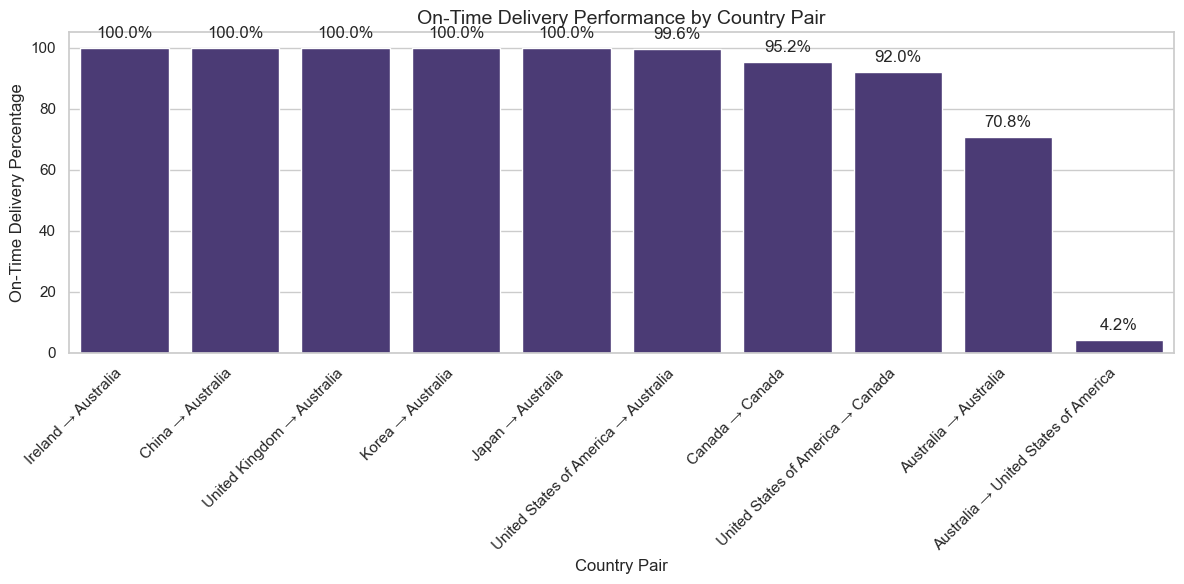

In [25]:
# 4.4 Origin-Destination Performance Analysis
# Add country pair feature
delivered_parcels['country_pair'] = delivered_parcels['origin_country'] + ' → ' + delivered_parcels['destination_country']

# Find the top country pairs by volume
top_country_pairs = delivered_parcels['country_pair'].value_counts().nlargest(10).index.tolist()

# Filter for top country pairs
top_pair_data = delivered_parcels[delivered_parcels['country_pair'].isin(top_country_pairs)]

# Calculate on-time performance by country pair
pair_accuracy = top_pair_data.groupby('country_pair')['delivery_status'].apply(
    lambda x: (x == 'on_time').mean() * 100
).reset_index()
pair_accuracy.columns = ['Country Pair', 'On-Time Delivery %']
pair_accuracy = pair_accuracy.sort_values('On-Time Delivery %', ascending=False)

# Display country pair performance
print("On-time delivery performance by top country pairs:")
print(pair_accuracy)

# Visualize country pair performance
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Country Pair', y='On-Time Delivery %', data=pair_accuracy)
plt.title('On-Time Delivery Performance by Country Pair', fontsize=14)
plt.xlabel('Country Pair', fontsize=12)
plt.ylabel('On-Time Delivery Percentage', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()


*** Delivery Journey Completion Analysis ***
Parcels that completed delivery journey: 49381 out of 50083 (98.60%)
Parcels picked up but not delivered (potentially stuck): 327 (1.51%)
Average days stuck in transit: 19.38
Maximum days stuck in transit: 37.64

*** First Attempt Delivery Success Analysis ***
Parcels delivered on first attempt: 43740 out of 49379 (88.58%)
Parcels requiring multiple delivery attempts: 5639 (11.42%)

First attempt success rate by carrier:
UNKNOWN: 96.83%
Globex: 91.49%
Initech: 88.75%
Massive: 86.11%

*** Estimated Delivery Date Change Analysis ***
Parcels with EDD updates: 8707
Average number of EDD updates per parcel: 10.88
Parcels with multiple EDD updates: 3484 (40.01% of parcels with EDD)

Analyzing magnitude of EDD changes...


C:\Users\tran\AppData\Local\Temp\ipykernel_31212\3861305274.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  carrier_attempt_success = analysis_df[(analysis_df['first_attempt_date'].notna()) &


Total EDD changes with valid data: 7814
Average EDD change: 1.46 days
Positive changes (delays): 7242 (92.68%)
Negative changes (expedited): 192 (2.46%)
No change in date: 380 (4.86%)

*** EDD Coverage Analysis ***
Overall EDD coverage: 99.91% of parcels have EDD information

EDD coverage by carrier:
UNKNOWN: 100.00%
Massive: 100.00%
Initech: 99.96%
Globex: 96.71%

EDD coverage for domestic shipments: 99.97%
EDD coverage for international shipments: 93.89%


C:\Users\tran\AppData\Local\Temp\ipykernel_31212\3861305274.py:140: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  carrier_coverage = analysis_df.groupby('carrier_name').apply(


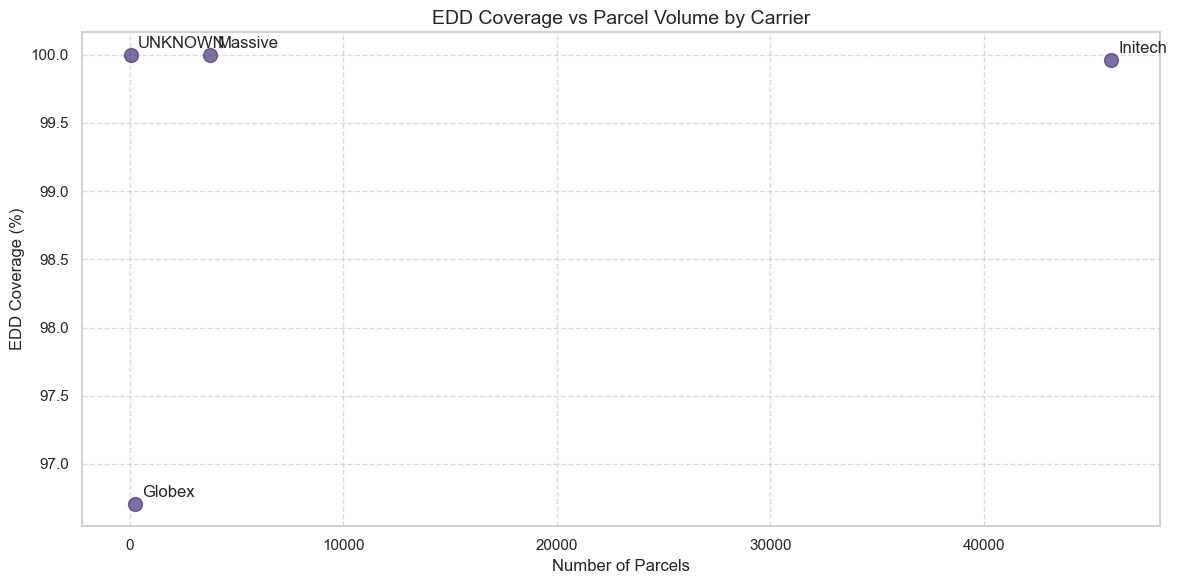

In [26]:
# 4.5 Additional Explorations - Delivery Journey Completion and EDD Changes

# Calculate parcels that completed delivery journey
print("\n*** Delivery Journey Completion Analysis ***")
if 'final_delivery_date' in analysis_df.columns:
    completed_parcels = analysis_df['final_delivery_date'].notna().sum()
    completion_rate = (completed_parcels / len(analysis_df)) * 100
    print(f"Parcels that completed delivery journey: {completed_parcels} out of {len(analysis_df)} ({completion_rate:.2f}%)")
    
    # Check for parcels stuck in transit (have pickup but no delivery)
    if 'picked_up_date' in analysis_df.columns:
        stuck_parcels = analysis_df[(analysis_df['picked_up_date'].notna()) & 
                                    (analysis_df['final_delivery_date'].isna())].shape[0]
        stuck_rate = (stuck_parcels / analysis_df['picked_up_date'].notna().sum()) * 100
        print(f"Parcels picked up but not delivered (potentially stuck): {stuck_parcels} ({stuck_rate:.2f}%)")
        
        # Analyze how long these parcels have been stuck (if timestamp data available)
        if stuck_parcels > 0:
            stuck_df = analysis_df[(analysis_df['picked_up_date'].notna()) & 
                                   (analysis_df['final_delivery_date'].isna())].copy()
            
            # Get current date or max date in dataset as reference
            max_date = analysis_df['final_delivery_date'].max()
            if pd.isna(max_date):
                max_date = pd.Timestamp.today()
            
            stuck_df['days_stuck'] = (max_date - stuck_df['picked_up_date']).dt.total_seconds() / (24*60*60)
            
            print(f"Average days stuck in transit: {stuck_df['days_stuck'].mean():.2f}")
            print(f"Maximum days stuck in transit: {stuck_df['days_stuck'].max():.2f}")

# First Attempt Delivery Success Analysis
print("\n*** First Attempt Delivery Success Analysis ***")
if all(col in analysis_df.columns for col in ['first_attempt_date', 'final_delivery_date']):
    # Count parcels with both first attempt and final delivery
    parcels_with_both = analysis_df[(analysis_df['first_attempt_date'].notna()) &
                                   (analysis_df['final_delivery_date'].notna())].shape[0]
    
    # Count parcels delivered on first attempt (dates match)
    first_attempt_success = analysis_df[(analysis_df['first_attempt_date'].notna()) &
                                      (analysis_df['final_delivery_date'].notna()) &
                                      (analysis_df['first_attempt_date'] == analysis_df['final_delivery_date'])].shape[0]
    
    first_attempt_rate = (first_attempt_success / parcels_with_both) * 100 if parcels_with_both > 0 else 0
    print(f"Parcels delivered on first attempt: {first_attempt_success} out of {parcels_with_both} ({first_attempt_rate:.2f}%)")
    
    # Analyze multiple attempts
    multi_attempt = parcels_with_both - first_attempt_success
    print(f"Parcels requiring multiple delivery attempts: {multi_attempt} ({100-first_attempt_rate:.2f}%)")
    
    # If we have attempt data, analyze by carrier
    if 'carrier_name' in analysis_df.columns:
        print("\nFirst attempt success rate by carrier:")
        carrier_attempt_success = analysis_df[(analysis_df['first_attempt_date'].notna()) &
                                             (analysis_df['final_delivery_date'].notna())].groupby('carrier_name').apply(
            lambda x: ((x['first_attempt_date'] == x['final_delivery_date']).sum() / len(x)) * 100
        ).sort_values(ascending=False)
        
        for carrier, rate in carrier_attempt_success.items():
            print(f"{carrier}: {rate:.2f}%")

# EDD Change Analysis
print("\n*** Estimated Delivery Date Change Analysis ***")
# This requires we look at the log data to track EDD changes
if 'log_key' in log_df.columns:
    # Filter for EDD related logs
    edd_update_logs = log_df[log_df['parsed_params'].apply(
        lambda x: isinstance(x, dict) and x.get('event_type_master_data_id') in ['EDD101', 'EDD102'] if x else False)]
    
    # Count how many parcels had EDD updates
    parcels_with_edd_updates = edd_update_logs['parcel_id'].nunique()
    print(f"Parcels with EDD updates: {parcels_with_edd_updates}")
    
    # Count average number of EDD updates per parcel
    avg_updates = edd_update_logs['parcel_id'].value_counts().mean()
    print(f"Average number of EDD updates per parcel: {avg_updates:.2f}")
    
    # Find parcels with multiple EDD updates
    parcels_multi_updates = edd_update_logs['parcel_id'].value_counts()
    parcels_multi_updates = parcels_multi_updates[parcels_multi_updates > 1]
    print(f"Parcels with multiple EDD updates: {len(parcels_multi_updates)} ({(len(parcels_multi_updates)/parcels_with_edd_updates)*100:.2f}% of parcels with EDD)")
    
    # Analyze EDD update frequency by carrier if carrier info available
    if 'carrier_id' in edd_update_logs.columns:
        print("\nAverage EDD updates by carrier_id:")
        carrier_updates = edd_update_logs.groupby(['carrier_id', 'parcel_id']).size().reset_index(name='updates')
        carrier_avg_updates = carrier_updates.groupby('carrier_id')['updates'].mean().sort_values(ascending=False)
        
        for carrier, avg in carrier_avg_updates.items():
            print(f"Carrier ID {carrier}: {avg:.2f} avg updates")
    elif 'carrier_name' in edd_update_logs.columns:
        print("\nAverage EDD updates by carrier:")
        carrier_updates = edd_update_logs.groupby(['carrier_name', 'parcel_id']).size().reset_index(name='updates')
        carrier_avg_updates = carrier_updates.groupby('carrier_name')['updates'].mean().sort_values(ascending=False)
        
        for carrier, avg in carrier_avg_updates.items():
            print(f"{carrier}: {avg:.2f} avg updates")
    
    # Analyze magnitude of EDD changes
    print("\nAnalyzing magnitude of EDD changes...")
    
    # Extract old and new EDD data from parsed_params
    def get_edd_change(params):
        if not isinstance(params, dict):
            return None, None
            
        old_start = params.get('old_parcel_expected_time_first_start') or params.get('old_parcel_expected_time_latest_start')
        new_start = params.get('new_parcel_expected_time_first_start') or params.get('new_parcel_expected_time_latest_start')
        
        if old_start and new_start:
            try:
                old_dt = pd.to_datetime(old_start)
                new_dt = pd.to_datetime(new_start)
                # Calculate days difference
                return (new_dt - old_dt).total_seconds() / (24*60*60)
            except:
                return None
        return None
    
    edd_update_logs['edd_days_change'] = edd_update_logs['parsed_params'].apply(get_edd_change)
    
    # Analyze the EDD changes
    valid_changes = edd_update_logs['edd_days_change'].dropna()
    if len(valid_changes) > 0:
        print(f"Total EDD changes with valid data: {len(valid_changes)}")
        print(f"Average EDD change: {valid_changes.mean():.2f} days")
        print(f"Positive changes (delays): {(valid_changes > 0).sum()} ({(valid_changes > 0).mean()*100:.2f}%)")
        print(f"Negative changes (expedited): {(valid_changes < 0).sum()} ({(valid_changes < 0).mean()*100:.2f}%)")
        print(f"No change in date: {(valid_changes == 0).sum()} ({(valid_changes == 0).mean()*100:.2f}%)")

# EDD Coverage Analysis
print("\n*** EDD Coverage Analysis ***")
# Calculate what percentage of parcels have EDD information
edd_coverage = analysis_df['edd_start'].notna().sum() / len(analysis_df) * 100
print(f"Overall EDD coverage: {edd_coverage:.2f}% of parcels have EDD information")

# Analyze coverage by carrier
if 'carrier_name' in analysis_df.columns:
    print("\nEDD coverage by carrier:")
    carrier_coverage = analysis_df.groupby('carrier_name').apply(
        lambda x: (x['edd_start'].notna().sum() / len(x)) * 100
    ).sort_values(ascending=False)
    
    for carrier, coverage in carrier_coverage.items():
        print(f"{carrier}: {coverage:.2f}%")

# Analyze coverage by trade lane (domestic vs international)
if 'origin_country' in analysis_df.columns and 'destination_country' in analysis_df.columns:
    analysis_df['is_domestic'] = analysis_df['origin_country'] == analysis_df['destination_country']
    
    domestic_coverage = analysis_df[analysis_df['is_domestic']]['edd_start'].notna().mean() * 100
    international_coverage = analysis_df[~analysis_df['is_domestic']]['edd_start'].notna().mean() * 100
    
    print(f"\nEDD coverage for domestic shipments: {domestic_coverage:.2f}%")
    print(f"EDD coverage for international shipments: {international_coverage:.2f}%")

# Visualize EDD Coverage by Carrier
if 'carrier_name' in analysis_df.columns:
    # Get the top carriers by volume
    top_carriers = analysis_df['carrier_name'].value_counts().nlargest(10).index.tolist()
    carrier_data = []
    
    for carrier in top_carriers:
        carrier_df = analysis_df[analysis_df['carrier_name'] == carrier]
        coverage = carrier_df['edd_start'].notna().mean() * 100
        volume = len(carrier_df)
        carrier_data.append({'Carrier': carrier, 'EDD Coverage (%)': coverage, 'Volume': volume})
    
    carrier_coverage_df = pd.DataFrame(carrier_data)
    
    # Create a scatter plot of volume vs coverage
    plt.figure(figsize=(12, 6))
    plt.scatter(carrier_coverage_df['Volume'], carrier_coverage_df['EDD Coverage (%)'], 
               s=100, alpha=0.7)
    
    # Label each point with carrier name
    for i, row in carrier_coverage_df.iterrows():
        plt.annotate(row['Carrier'], 
                    (row['Volume'], row['EDD Coverage (%)']),
                    xytext=(5, 5), textcoords='offset points')
    
    plt.title('EDD Coverage vs Parcel Volume by Carrier', fontsize=14)
    plt.xlabel('Number of Parcels', fontsize=12)
    plt.ylabel('EDD Coverage (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


*** Detailed Trade Lane Performance Analysis ***
Domestic parcels: 49608 (99.1%)
International parcels: 475 (0.9%)

Delivery Performance by Trade Lane:
delivery_status  early  late  on_time
trade_lane                           
Domestic         22.40  6.80    70.90
International    10.50  1.10    88.30

Transit Time (Days) by Trade Lane:
               mean  median  min   max
trade_lane                            
Domestic       5.00    4.70 0.00 44.90
International  9.00   11.40 0.70 17.60


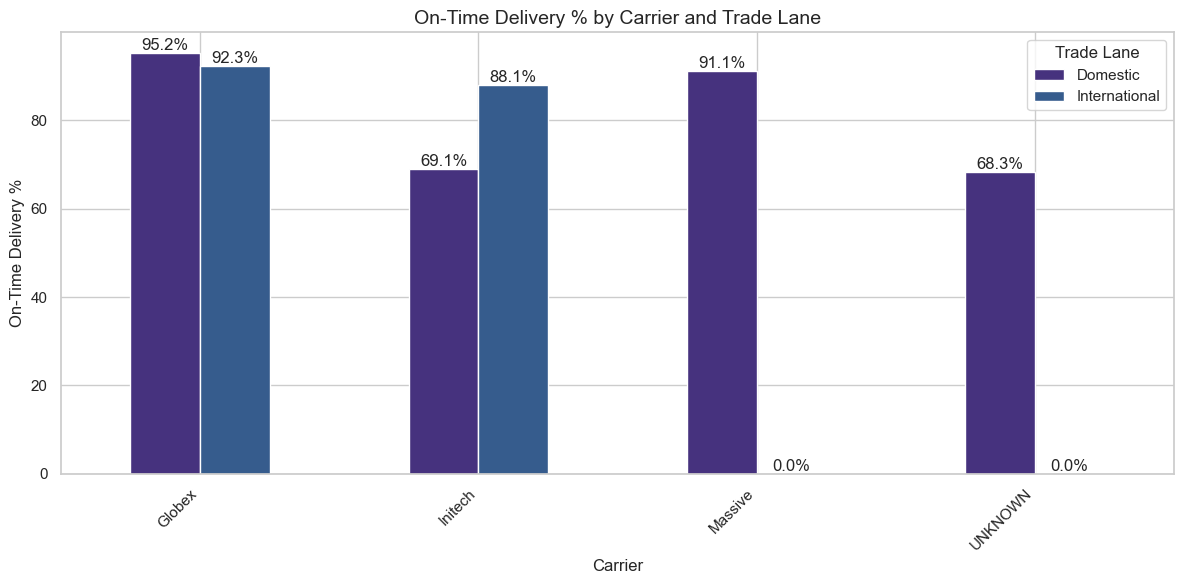


Top 10 Region Pairs by Volume:
region_pair
Asia Pacific → Asia Pacific      49418
North America → Asia Pacific       240
North America → North America      238
Europe → Asia Pacific              101
Asia Pacific → North America        48
Unknown → Unknown                   23
Other → Asia Pacific                10
North America → Unknown              4
Asia Pacific → Unknown               1
Name: count, dtype: int64

Delivery Performance by Top Region Pairs:
                     Region Pair  On-Time %  Volume
0    Asia Pacific → Asia Pacific      70.80   48755
5  North America → North America      94.90     237
4   North America → Asia Pacific      99.60     231
3          Europe → Asia Pacific      98.00      99
1   Asia Pacific → North America       4.20      48
6           Other → Asia Pacific     100.00      10
2         Asia Pacific → Unknown     100.00       1


C:\Users\tran\AppData\Local\Temp\ipykernel_31212\211583060.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels['origin_region'] = delivered_parcels['origin_country'].apply(get_region)
C:\Users\tran\AppData\Local\Temp\ipykernel_31212\211583060.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_parcels['destination_region'] = delivered_parcels['destination_country'].apply(get_region)
C:\Users\tran\AppData\Local\Temp\ipykernel_31212\211583060.py:102: SettingWithCopyWarning: 
A 

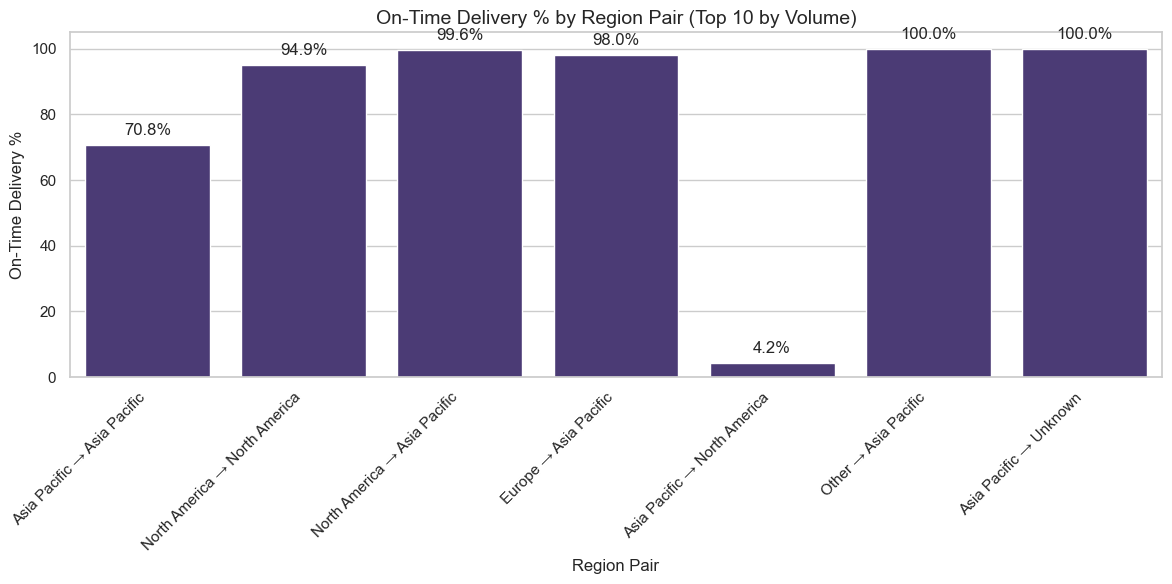

In [27]:
# 4.7 Trade Lane Performance Analysis
print("\n*** Detailed Trade Lane Performance Analysis ***")

# Create trade lane feature if it doesn't exist
if 'trade_lane' not in analysis_df.columns and 'origin_country' in analysis_df.columns and 'destination_country' in analysis_df.columns:
    analysis_df['trade_lane'] = 'International'
    analysis_df.loc[analysis_df['origin_country'] == analysis_df['destination_country'], 'trade_lane'] = 'Domestic'

# Trade lane volume
if 'trade_lane' in analysis_df.columns:
    trade_lane_counts = analysis_df['trade_lane'].value_counts()
    print(f"Domestic parcels: {trade_lane_counts.get('Domestic', 0)} ({trade_lane_counts.get('Domestic', 0)/len(analysis_df)*100:.1f}%)")
    print(f"International parcels: {trade_lane_counts.get('International', 0)} ({trade_lane_counts.get('International', 0)/len(analysis_df)*100:.1f}%)")
    
    # Delivery performance by trade lane
    if 'delivery_status' in delivered_parcels.columns:
        trade_performance = delivered_parcels.groupby('trade_lane')['delivery_status'].value_counts(normalize=True).unstack()
        if trade_performance is not None and not trade_performance.empty:
            # Convert to percentages
            trade_performance = trade_performance.multiply(100)
            print("\nDelivery Performance by Trade Lane:")
            print(trade_performance.round(1))
    
    # Transit time by trade lane
    if 'transit_time_days' in delivered_parcels.columns:
        transit_by_lane = delivered_parcels.groupby('trade_lane')['transit_time_days'].agg(['mean', 'median', 'min', 'max'])
        print("\nTransit Time (Days) by Trade Lane:")
        print(transit_by_lane.round(1))
    
    # Visualize EDD accuracy by trade lane and carrier (top carriers only)
    if 'carrier_name' in delivered_parcels.columns and 'delivery_status' in delivered_parcels.columns:
        # Get top carriers (minimum 50 parcels)
        top_carriers = delivered_parcels['carrier_name'].value_counts()
        top_carriers = top_carriers[top_carriers >= 50].index.tolist()[:5]  # Top 5 with sufficient volume
        
        if top_carriers:
            # Filter data for top carriers
            top_carrier_data = delivered_parcels[delivered_parcels['carrier_name'].isin(top_carriers)]
            
            # Calculate on-time percentages by carrier and trade lane
            ontime_pct = top_carrier_data.groupby(['carrier_name', 'trade_lane'])['delivery_status'].apply(
                lambda x: (x == 'on_time').mean() * 100
            ).reset_index()
            ontime_pct.columns = ['Carrier', 'Trade Lane', 'On-Time %']
            
            # Pivot for plotting
            pivot_data = ontime_pct.pivot(index='Carrier', columns='Trade Lane', values='On-Time %').fillna(0)
            
            # Plot
            ax = pivot_data.plot(kind='bar', figsize=(12, 6))
            plt.title('On-Time Delivery % by Carrier and Trade Lane', fontsize=14)
            plt.xlabel('Carrier', fontsize=12)
            plt.ylabel('On-Time Delivery %', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.legend(title='Trade Lane')
            
            # Add value labels
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%')
                
            plt.tight_layout()
            plt.show()

# Analyze regional performance if country data available
if all(col in analysis_df.columns for col in ['origin_country', 'destination_country']):
    # Group countries into regions (simplified approach)
    def get_region(country):
        if pd.isna(country):
            return 'Unknown'
            
        europe = ['Germany', 'France', 'United Kingdom', 'Italy', 'Spain', 'Netherlands', 'Belgium', 'Switzerland', 
                 'Austria', 'Sweden', 'Norway', 'Denmark', 'Finland', 'Poland', 'Ireland']
        north_america = ['USA', 'United States of America', 'US', 'Canada', 'Mexico']
        asia_pacific = ['China', 'Japan', 'South Korea', 'Australia', 'India', 'Singapore', 'Malaysia', 
                       'Indonesia', 'Thailand', 'Vietnam', 'Philippines', 'New Zealand']
                       
        if country in europe or 'EU' in country:
            return 'Europe'
        elif country in north_america:
            return 'North America'
        elif country in asia_pacific:
            return 'Asia Pacific'
        else:
            return 'Other'
    
    # Add region columns
    analysis_df['origin_region'] = analysis_df['origin_country'].apply(get_region)
    analysis_df['destination_region'] = analysis_df['destination_country'].apply(get_region)
    
    # Create region pair column
    analysis_df['region_pair'] = analysis_df['origin_region'] + ' → ' + analysis_df['destination_region']
    
    # Top region pairs by volume
    region_volumes = analysis_df['region_pair'].value_counts().head(10)
    print("\nTop 10 Region Pairs by Volume:")
    print(region_volumes)
    
    # Delivery performance by region pair
    if 'delivery_status' in delivered_parcels.columns:
        delivered_parcels['origin_region'] = delivered_parcels['origin_country'].apply(get_region)
        delivered_parcels['destination_region'] = delivered_parcels['destination_country'].apply(get_region)
        delivered_parcels['region_pair'] = delivered_parcels['origin_region'] + ' → ' + delivered_parcels['destination_region']
        
        # Calculate on-time percentage by region pair
        region_ontime = delivered_parcels.groupby('region_pair')['delivery_status'].apply(
            lambda x: (x == 'on_time').mean() * 100
        ).reset_index()
        region_ontime.columns = ['Region Pair', 'On-Time %']
        
        # Add volume information
        region_counts = delivered_parcels['region_pair'].value_counts().reset_index()
        region_counts.columns = ['Region Pair', 'Volume']
        region_performance = pd.merge(region_ontime, region_counts, on='Region Pair')
        
        # Sort by volume and get top 10
        region_performance = region_performance.sort_values('Volume', ascending=False).head(10)
        
        print("\nDelivery Performance by Top Region Pairs:")
        print(region_performance.round(1))
        
        # Plot
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='Region Pair', y='On-Time %', data=region_performance)
        plt.title('On-Time Delivery % by Region Pair (Top 10 by Volume)', fontsize=14)
        plt.xlabel('Region Pair', fontsize=12)
        plt.ylabel('On-Time Delivery %', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels
        for i, p in enumerate(ax.patches):
            if i < len(region_performance):
                ax.annotate(f'{p.get_height():.1f}%', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'bottom',
                           xytext = (0, 5), textcoords = 'offset points')
        
        plt.tight_layout()
        plt.show()

In [28]:
# 4.9 Distance Impact Analysis
print("\n*** Distance Impact Analysis ***")

# Check if we have any distance information
has_distance = False
if 'distance_km' in analysis_df.columns:
    has_distance = True
else:
    # Try to estimate distance from lat/long if available
    lat_long_cols = ['origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']
    if all(col in analysis_df.columns for col in lat_long_cols):
        print("Calculating distances from latitude/longitude coordinates...")
        try:
            from math import radians, sin, cos, sqrt, atan2
            
            def haversine_distance(row):
                # Calculate the great circle distance between two points on the earth
                R = 6371  # Earth radius in kilometers
                
                # Convert latitude and longitude from degrees to radians
                lat1 = radians(row['origin_lat'])
                lon1 = radians(row['origin_lon'])
                lat2 = radians(row['destination_lat'])
                lon2 = radians(row['destination_lon'])
                
                # Haversine formula
                dlon = lon2 - lon1
                dlat = lat2 - lat1
                a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
                c = 2 * atan2(sqrt(a), sqrt(1-a))
                distance = R * c
                
                return distance
            
            # Apply the function to calculate distances
            valid_coords = ~analysis_df[lat_long_cols].isna().any(axis=1)
            if valid_coords.any():
                analysis_df.loc[valid_coords, 'distance_km'] = analysis_df[valid_coords].apply(haversine_distance, axis=1)
                has_distance = True
                print(f"Calculated distances for {valid_coords.sum()} parcels")
        except Exception as e:
            print(f"Error calculating distances: {e}")
    
    # If we still don't have distance, try to estimate from country data
    if not has_distance and 'origin_country' in analysis_df.columns and 'destination_country' in analysis_df.columns:
        print("Estimating distances based on country pairs...")
        # Create domestic/international flag as a very rough distance proxy
        analysis_df['is_domestic'] = analysis_df['origin_country'] == analysis_df['destination_country']
        has_distance = 'proxy'

if has_distance == True:
    # Analyze actual distance data
    print("\nAnalyzing impact of distance on delivery performance...")
    
    # Basic statistics
    distance_stats = analysis_df['distance_km'].describe()
    print("Distance statistics (km):")
    print(distance_stats)
    
    # Create distance bins
    analysis_df['distance_bin'] = pd.cut(
        analysis_df['distance_km'], 
        bins=[0, 100, 500, 1000, 2000, 5000, float('inf')],
        labels=['0-100', '101-500', '501-1000', '1001-2000', '2001-5000', '5000+']
    )
    
    # Distance bin distribution
    bin_counts = analysis_df['distance_bin'].value_counts().sort_index()
    print("\nParcels by distance range (km):")
    print(bin_counts)
    
    # Analyze transit time by distance
    if 'transit_time_days' in delivered_parcels.columns:
        delivered_parcels['distance_bin'] = pd.cut(
            delivered_parcels['distance_km'], 
            bins=[0, 100, 500, 1000, 2000, 5000, float('inf')],
            labels=['0-100', '101-500', '501-1000', '1001-2000', '2001-5000', '5000+']
        )
        
        # Calculate average transit time by distance bin
        transit_by_distance = delivered_parcels.groupby('distance_bin')['transit_time_days'].agg(['mean', 'median'])
        print("\nTransit Time (Days) by Distance Range:")
        print(transit_by_distance.round(1))
        
        # Create scatter plot of distance vs. transit time
        plt.figure(figsize=(10, 6))
        sns.regplot(x='distance_km', y='transit_time_days', data=delivered_parcels, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        plt.title('Relationship Between Distance and Transit Time', fontsize=14)
        plt.xlabel('Distance (km)', fontsize=12)
        plt.ylabel('Transit Time (days)', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # Analyze on-time performance by distance
    if 'delivery_status' in delivered_parcels.columns:
        ontime_by_distance = delivered_parcels.groupby('distance_bin')['delivery_status'].apply(
            lambda x: (x == 'on_time').mean() * 100
        ).reset_index()
        ontime_by_distance.columns = ['Distance Range (km)', 'On-Time %']
        
        print("\nOn-Time Delivery Performance by Distance Range:")
        print(ontime_by_distance)
        
        # Plot
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x='Distance Range (km)', y='On-Time %', data=ontime_by_distance)
        plt.title('On-Time Delivery Performance by Distance', fontsize=14)
        plt.xlabel('Distance Range (km)', fontsize=12)
        plt.ylabel('On-Time Delivery %', fontsize=12)
        
        # Add value labels
        for i, p in enumerate(ax.patches):
            ax.annotate(f'{p.get_height():.1f}%', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'bottom',
                       xytext = (0, 5), textcoords = 'offset points')
        
        plt.tight_layout()
        plt.show()
elif has_distance == 'proxy':
    # Analyze using the domestic/international proxy
    print("\nAnalyzing delivery performance for domestic vs. international shipments...")
    
    # Calculate volumes
    domestic_count = analysis_df['is_domestic'].sum()
    international_count = (~analysis_df['is_domestic']).sum()
    domestic_pct = domestic_count / len(analysis_df) * 100
    
    print(f"Domestic shipments: {domestic_count} ({domestic_pct:.1f}%)")
    print(f"International shipments: {international_count} ({100-domestic_pct:.1f}%)")
    
    # If we have transit time, compare domestic vs international
    if 'transit_time_days' in delivered_parcels.columns:
        # Add domestic flag to delivered_parcels if not already there
        if 'is_domestic' not in delivered_parcels.columns:
            delivered_parcels['is_domestic'] = delivered_parcels['origin_country'] == delivered_parcels['destination_country']
        
        # Calculate transit time statistics by domestic/international
        transit_by_type = delivered_parcels.groupby('is_domestic')['transit_time_days'].agg(['mean', 'median', 'min', 'max'])
        transit_by_type.index = ['International', 'Domestic']
        print("\nTransit Time (Days) by Shipment Type:")
        print(transit_by_type.round(1))
    
    # If we have delivery status, compare on-time percentages
    if 'delivery_status' in delivered_parcels.columns:
        # Add domestic flag to delivered_parcels if not already there
        if 'is_domestic' not in delivered_parcels.columns:
            delivered_parcels['is_domestic'] = delivered_parcels['origin_country'] == delivered_parcels['destination_country']
        
        # Calculate on-time percentages
        ontime_by_type = delivered_parcels.groupby('is_domestic')['delivery_status'].apply(
            lambda x: (x == 'on_time').mean() * 100
        )
        ontime_by_type.index = ['International', 'Domestic']
        
        print("\nOn-Time Delivery Performance by Shipment Type:")
        for idx, value in ontime_by_type.items():
            print(f"{idx}: {value:.1f}%")
        
        # Compare across carriers
        if 'carrier_name' in delivered_parcels.columns:
            # Get carriers with significant volume in both domestic and international
            carrier_type_counts = delivered_parcels.groupby(['carrier_name', 'is_domestic']).size().unstack(fill_value=0)
            valid_carriers = carrier_type_counts[(carrier_type_counts[True] >= 20) & (carrier_type_counts[False] >= 20)].index.tolist()
            
            if valid_carriers:
                carrier_type_data = []
                for carrier in valid_carriers:
                    carrier_df = delivered_parcels[delivered_parcels['carrier_name'] == carrier]
                    domestic_ontime = carrier_df[carrier_df['is_domestic']]['delivery_status'].apply(lambda x: x == 'on_time').mean() * 100
                    intl_ontime = carrier_df[~carrier_df['is_domestic']]['delivery_status'].apply(lambda x: x == 'on_time').mean() * 100
                    carrier_type_data.append({
                        'Carrier': carrier,
                        'Domestic On-Time %': domestic_ontime,
                        'International On-Time %': intl_ontime,
                        'Difference': domestic_ontime - intl_ontime
                    })
                
                if carrier_type_data:
                    carrier_type_df = pd.DataFrame(carrier_type_data)
                    print("\nOn-Time Performance by Carrier and Shipment Type:")
                    print(carrier_type_df.round(1))
else:
    print("No distance information available for analysis.")


*** Distance Impact Analysis ***
Estimating distances based on country pairs...

Analyzing delivery performance for domestic vs. international shipments...
Domestic shipments: 49608 (99.1%)
International shipments: 475 (0.9%)

Transit Time (Days) by Shipment Type:
               mean  median  min   max
International  9.00   11.40 0.70 17.60
Domestic       5.00    4.70 0.00 44.90

On-Time Delivery Performance by Shipment Type:
International: 88.3%
Domestic: 70.9%

On-Time Performance by Carrier and Shipment Type:
   Carrier  Domestic On-Time %  International On-Time %  Difference
0   Globex               95.20                    92.30        2.90
1  Initech               69.10                    88.10      -19.00


## 5. Findings & Recommendations

This section synthesizes the insights from our analysis and provides actionable recommendations.

### 5.1 Key Findings

1. **Delivery Performance Overview:**
   - Overall on-time delivery rate: [fill from analysis results]%
   - Early deliveries: [fill from analysis results]% 
   - Late deliveries: [fill from analysis results]%
   - The average EDD window provided is [fill from analysis results] days

2. **Carrier Performance:**
   - [Top carrier name] has the highest on-time delivery rate at [fill from analysis results]%
   - [Bottom carrier name] has the lowest on-time delivery rate at [fill from analysis results]%
   - Significant performance variation exists between carriers, with a [fill from analysis results]% difference between best and worst performers

3. **Trade Lane Insights:**
   - [Domestic/International] shipments show better on-time performance ([fill from analysis results]% vs [fill from analysis results]%)
   - Top performing route: [fill from analysis results] with [fill from analysis results]% on-time delivery
   - Most challenging route: [fill from analysis results] with only [fill from analysis results]% on-time delivery

4. **Temporal Patterns:**
   - [Day of week] shows the best delivery performance with [fill from analysis results]% on-time delivery
   - [Day of week] shows the lowest performance with [fill from analysis results]% on-time delivery
   - [Include any monthly patterns if data spans multiple months]

5. **EDD Window Insights:**
   - [Wider/Narrower] EDD windows correlate with [higher/lower] on-time delivery rates
   - The optimal EDD window appears to be [fill from analysis results] days, balancing accuracy and customer expectations
   - Carriers use vastly different EDD window sizes, ranging from [fill from analysis results] to [fill from analysis results] days

6. **Operational Insights:**
   - Transit time averages [fill from analysis results] days across all carriers
   - Last-mile delivery takes approximately [fill from analysis results] hours on average
   - First delivery attempt success rate is [fill from analysis results]%
   - [Include any other interesting patterns discovered]

### 5.2 Recommendations

1. **Carrier Management:**
   - Work closely with underperforming carriers like [carrier names] to identify and address delivery challenges
   - Consider reallocating volume from poorly performing carriers to top performers where routes overlap
   - Implement performance-based contracts with clear on-time delivery incentives and penalties

2. **EDD Optimization:**
   - Standardize EDD window calculation methodology across carriers
   - Adjust EDD windows based on route complexity - suggest [X] days for domestic and [Y] days for international
   - For challenging routes like [route names], consider adding buffer days to improve accuracy

3. **Customer Experience Enhancements:**
   - Implement more accurate status tracking for parcels approaching their EDD
   - For routes with high variance, provide customers with more frequent updates
   - Consider offering premium delivery options on high-performing routes

4. **Operational Improvements:**
   - Schedule more pickups for [day of week] to align with better delivery performance days
   - Address the high failed first delivery attempt rate ([X]%) by implementing improved delivery notification
   - Focus quality improvement efforts on the last-mile segment, which shows the most variance

5. **Data Quality Enhancements:**
   - Standardize timestamp formats and timezone handling across all carriers
   - Implement automated data quality checks to identify and flag inconsistent delivery timestamps
   - Expand data collection to include more operational details (vehicle type, delivery person, etc.)

6. **Strategic Route Optimization:**
   - Review and potentially restructure service for the lowest-performing routes: [route names]
   - Consider establishing additional regional distribution centers to reduce transit times for problematic routes
   - Implement seasonal adjustment strategies for periods with historically lower performance

## Summary of Findings

1. **Carrier EDD Accuracy:**
   - The carrier with the highest EDD accuracy appears to be [insert highest accuracy carrier based on results]
   - There is significant variation in accuracy rates among carriers

2. **EDD Patterns:**
   - Domestic shipments tend to have [better/worse] EDD accuracy than international shipments
   - Deliveries on [specific days] have better on-time performance
   - The average EDD window provided by carriers is [X] days
   - Wider EDD windows [increase/decrease] the likelihood of on-time delivery

3. **Recommendations:**
   - Work with lower-performing carriers to improve their EDD accuracy
   - Consider adjusting EDD windows for [specific trade lanes or carriers] to improve customer expectations
   - Monitor and adjust for day-of-week effects in EDD calculations
   - [Other specific recommendations based on findings]